In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter
import numpy as np
import os
import warnings
import re
import time
import itertools
import pickle

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import gensim #word2vec
from gensim.models import Word2Vec

import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential 
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM 
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras import utils


In [3]:
#voir les variables déclarées
whos

NameError: name 'whos' is not defined

In [12]:
len(df)

1600000

# Charge the data

In [11]:

names = ["target","ids","date","flag","user","text"]
df = pd.read_csv("training.1600000.processed.noemoticon.csv",encoding = "latin-1", names = names)
print("Dataset size :",len(df))

Dataset size : 1600000


In [13]:
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


Map target label to String
- 0 -> NEGATIVE
- 2 -> NEUTRAL
- 4 -> POSITIVE

In [14]:

decode_map = {0 : "NEGATIVE",2 : "NEUTRAL", 4 : "POSITIVE"}
df.target = df.target.apply(lambda x : decode_map[x])
df.head()

,target,ids,date,flag,user,text
0,NEGATIVE,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,NEGATIVE,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,NEGATIVE,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,NEGATIVE,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,NEGATIVE,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


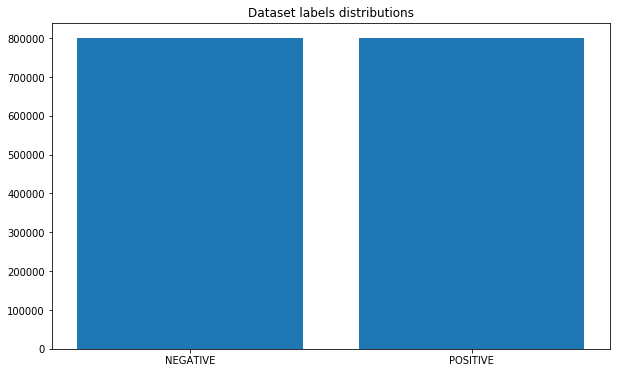

In [15]:
target_cnt = Counter(df.target)

plt.figure(figsize = (10,6))
plt.bar(target_cnt.keys(),target_cnt.values())
plt.title("Dataset labels distributions")
plt.show()

## Pre-process data 

Using stopwords might reduce the model performance. Some words like 'not' are included in stopwords and ignoring them will make sentences like 'this was good' and 'this was not good' have same predictions.

In [16]:
stop_words = stopwords.words("english")
stop_words.remove("not") 
stemmer = SnowballStemmer("english")

In [17]:

def preprocess(text,stem = False) :
    pattern = r'@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+' #r'@\S+|http\S+|[^A-Za-z0-9]+' 
    text = re.sub(pattern, " ",str(text).lower()).strip()
    text = " ".join([text_ for text_ in text.split() if text_ not in stop_words])
    if stem :
        
        text = " ".join([stemmer.stem(text_) for text_ in text.split()])
    
    return text
    
df.text = df.text.apply(lambda x : preprocess(x))
df.head()

,target,ids,date,flag,user,text
0,NEGATIVE,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,awww bummer shoulda got david carr third day
1,NEGATIVE,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,upset update facebook texting might cry result...
2,NEGATIVE,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,dived many times ball managed save 50 rest go ...
3,NEGATIVE,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,whole body feels itchy like fire
4,NEGATIVE,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,not behaving mad see


# split train/test 

In [18]:
df_train, df_test = train_test_split(df, test_size = 0.2, random_state = 42)
print("Train size :",len(df_train))
print("Test size :",len(df_test))

Train size : 1280000
Test size : 320000


# Word2Vec

Word2Vec va nous servir pour la couche d'embedding, donc pas tout de suite

In [19]:

documents = [_text.split() for _text in df_train.text]

W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

w2v_model = gensim.models.word2vec.Word2Vec(size = W2V_SIZE,
                                           window = W2V_WINDOW,
                                           min_count = W2V_MIN_COUNT,
                                           workers = 8)
w2v_model.build_vocab(documents)

In [20]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size :",vocab_size)

Vocab size : 30370


In [21]:

w2v_model.train(documents, total_examples = len(documents), epochs = W2V_EPOCH)

(264543663, 298054304)

In [22]:
w2v_model.most_similar("love")

C:\Users\badre\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('luv', 0.5840849280357361),
 ('loves', 0.5672263503074646),
 ('loved', 0.5314806699752808),
 ('adore', 0.5051390528678894),
 ('amazing', 0.5037234425544739),
 ('looove', 0.4898017346858978),
 ('loveee', 0.48025161027908325),
 ('awesome', 0.47475117444992065),
 ('lovee', 0.45713791251182556),
 ('miss', 0.439153254032135)]

# Tokenize Text

In [23]:

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text) #chaque mot est associé à un numéro, par exemple "good" : 65645

vocab_size = len(tokenizer.word_index) + 1 # +1 pour UNK words
print("Total words", vocab_size)

Total words 290420


In [24]:


SEQUENCE_LENGTH = 300

#on transforme chaque phrase en suite d'element indicé grace au tokenizer
#on pad pour avoir la même longueur
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen = SEQUENCE_LENGTH) 
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text),maxlen = SEQUENCE_LENGTH)

# Label Encoder

0 c'est sentiment positive et 1 c'est sentiment négatif, il faut que chaque élément soit sous forme de liste [1] ou [0] pour que keras marche 

In [ ]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())
y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)


print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [ ]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 300)
y_train (1280000, 1)

x_test (320000, 300)
y_test (320000, 1)


# Embedding layer

on se sert de word2vec

In [ ]:
embedding_matrix = np.zeros((vocab_size,W2V_SIZE)) #ligne de la matrice d'embedding sont les mots et les colonnes l'encodage du mot

for word, i in tokenizer.word_index.items(): #tokenizer.word_index c'est le dico {mot : i for (mot,i) in enumerate(nombres_mots)}
    if word in w2v_model.wv : #si le mot est dans le w2v construit
        embedding_matrix[i] = w2v_model.wv[word] #on met à la ligne correspond au mot son encodage w2v

print(embedding_matrix.shape)

(290420, 300)


In [ ]:
embedding_layer = Embedding(vocab_size, W2V_SIZE , weights = [embedding_matrix], 
                            input_length = SEQUENCE_LENGTH, trainable = False)

# Model

In [ ]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100,dropout = 0.2, recurrent_dropout = 0.2))
model.add(Dense(1,activation = 'sigmoid'))

model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          87126000  
_________________________________________________________________
dropout_1 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 87,286,501
Trainable params: 160,501
Non-trainable params: 87,126,000
_________________________________________________________________


In [ ]:
model.compile(loss = "binary_crossentropy", 
             optimizer = "adam",
             metrics = ["accuracy"])


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
callbacks = [ ReduceLROnPlateau(monitor="val_loss", patience = 3, cooldown = 0),
            EarlyStopping(monitor = "val_acc", min_delta = 1e-4, patience = 5)]

# Train

In [ ]:

EPOCHS = 5
BATCH_SIZE = 1024


history = model.fit(x_train, y_train,
                   batch_size = BATCH_SIZE,
                   epochs = EPOCHS,
                   validation_split = 0.1,
                   verbose = 1,
                   callbacks = callbacks)

Train on 1152000 samples, validate on 128000 samples
Epoch 1/5
 132096/1152000 [==>...........................] - ETA: 5:20:22 - loss: 0.5506 - acc: 0.7169

# Evaluate

In [319]:
%%time 
score = model.evaluate(x_test,y_test, batch_size = BATCH_SIZE)
print()
print("ACCURACY :",score[1])
print("LOSS :",score[0])

320000/320000 [==============================] - 338s 1ms/step

ACCURACY : 0.7885156273841858
LOSS : 0.448554283618927
CPU times: user 19min 57s, sys: 9min 23s, total: 29min 20s
Wall time: 5min 38s


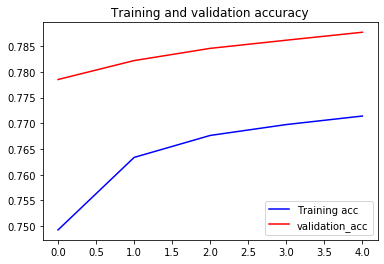

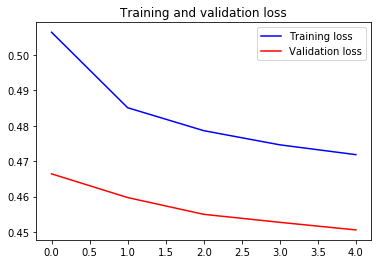

In [326]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label = 'Training acc' )
plt.plot(epochs , val_acc,'r', label = 'validation_acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title("Training and validation loss")
plt.legend()

plt.show()

In [3]:
SENTIMENT_THRESHOLDS = (0.4, 0.7)
SEQUENCE_LENGTH = 300
def decode_sentiment(score, include_neutral = True):
    if include_neutral : 
        label = "NEUTRAL"
        if score <= SENTIMENT_THRESHOLDS[0] :
            label = "NEGATIVE"
        elif score >= SENTIMENT_THRESHOLDS[1] :
            label = "POSITIVE"
        
        return label
    else : 
        return "NEGATIVE" if score < 0.5 else "POSITIVE"
    
    

In [5]:
#on doit preprocesser les phrases que l'on passe dans le modèle et cela nous permet de le faire
def predict(text, include_neutral = True) : 
    start_at = time.time()
    
    #on doit tokenizer la phrase puis pad la séquences pour le passer dans notre modèle
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen = SEQUENCE_LENGTH)
    
    score = model.predict([x_test])[0] #on trouve la probabilité associé
    
    label = decode_sentiment(score,include_neutral = include_neutral) #on la classe en positive ou négative
    
    return {"label" : label , "score": float(score),
           "elapsed time": time.time()-start_at}


In [390]:
predict("I love the music")

{'label': 'POSITIVE',
 'score': 0.9775521755218506,
 'elapsed time': 0.020482778549194336}

In [391]:
predict("I hate the rain")


{'label': 'NEGATIVE',
 'score': 0.012892383150756359,
 'elapsed time': 0.021337032318115234}

In [392]:
predict("i don't know what i'm doing")

{'label': 'NEGATIVE',
 'score': 0.3571109175682068,
 'elapsed time': 0.02018117904663086}

In [395]:
predict("The euroscepticism gain european countries",include_neutral = False)

{'label': 'NEGATIVE',
 'score': 0.4919613301753998,
 'elapsed time': 0.024986982345581055}

# Confusion matrix

In [344]:
%%time 
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose = 1, batch_size = 8000) #donne une proba
y_pred_1d = [decode_sentiment(score, include_neutral = False) for score in scores] #transforme en positive/negative/neutral

320000/320000 [==============================] - 456s 1ms/step
CPU times: user 19min 46s, sys: 12min 34s, total: 32min 20s
Wall time: 7min 36s


In [352]:
def plot_confusion_matrix(cm, classes, title = 'Confusion matrix', cmap = plt.cm.Blues) : 
    
    "Print and plot the confusion matrix"
    
    cm = cm.astype('float') / cm.sum(axis= 1) [:,np.newaxis]
    
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title, fontsize = 30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 90, fontsize = 32)
    plt.yticks(tick_marks, classes, fontsize = 22)
    
    fmt = '.2f'
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]),range(cm.shape[1])) :
        plt.text(j,i, format(cm[i,j], fmt),
                horizontalalignment = 'center',
                color = "white" if cm[i,j] > thresh else "black") 
        
    plt.ylabel("True label", fontsize = 25)
    plt.xlabel("Predict label", fontsize = 25)

In [368]:
cnf_matrix

array([[123946,  35548],
       [ 32127, 128379]])

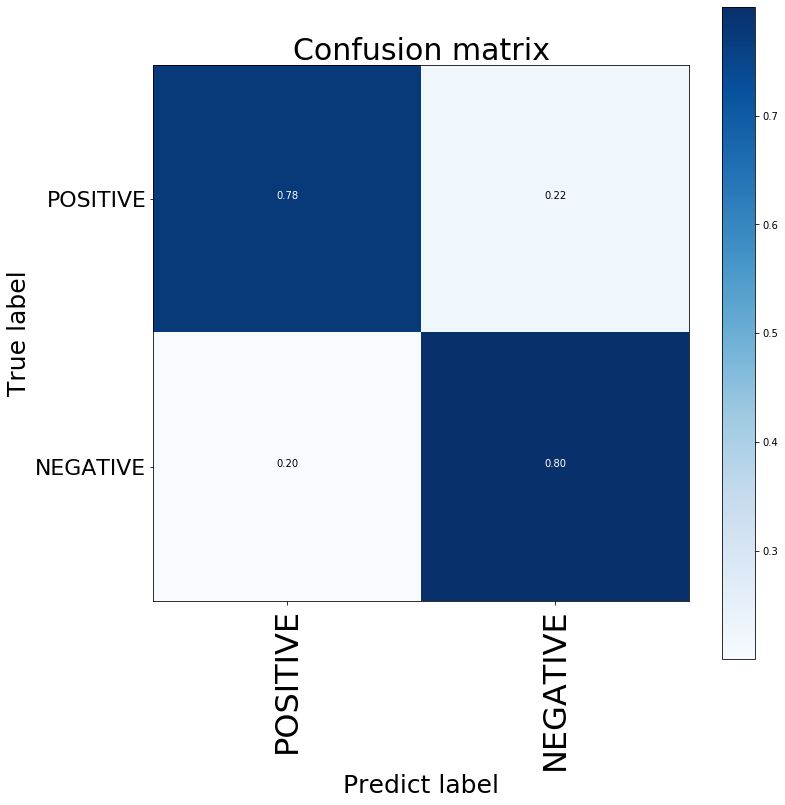

CPU times: user 949 ms, sys: 46.4 ms, total: 995 ms
Wall time: 1 s


In [353]:
%%time 

cnf_matrix = confusion_matrix(y_test_1d,y_pred_1d) #donne le résultat de la matrice 
plt.figure(figsize = (12,12))
plot_confusion_matrix(cnf_matrix, classes = df_train.target.unique(), title = "Confusion matrix")
plt.show()

# Classification report

In [8]:
print(classification_report(y_test_1d, y_pred_1d))

NameError: name 'y_test_1d' is not defined

# Accuracy Score

In [355]:
accuracy_score(y_test_1d, y_pred_1d)

0.788515625

# Save model

The models are saved for use later.

You can load the models and then use the predict function to predict sentiment for the text.

Keep in mind that you need to preprocess the text and encode it before prediction.

In [357]:
# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"



model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL,"wb"),protocol = 0)
pickle.dump(encoder, open(ENCODER_MODEL,"wb"), protocol = 0)

# Load model 

We charge the model and we continue to train the model, tokenizer, word2vec ect..

In [7]:
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"
model = keras.models.load_model("model.h5")
tokenizer = pickle.load(open(TOKENIZER_MODEL,"rb"))
encoder = pickle.load(open(ENCODER_MODEL,"rb"))
w2v_model = Word2Vec.load("model.w2v")

C:\Users\badre\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.22.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [8]:
predict("The country is losing a lot of money unfortunately")

{'label': 'NEGATIVE',
 'score': 0.05846598744392395,
 'elapsed time': 0.46774816513061523}

In [9]:
predict("UAE is in good shape")

{'label': 'POSITIVE',
 'score': 0.8528748750686646,
 'elapsed time': 0.06682085990905762}

In [10]:
predict("How the EU is helping railways ride out Covid-19", False)

{'label': 'POSITIVE',
 'score': 0.6983655095100403,
 'elapsed time': 0.059888601303100586}

In [11]:
predict("France chaos: Macron faces Frexit demands after EU 'abandoned' states during pandemic",False)

{'label': 'NEGATIVE',
 'score': 0.20795145630836487,
 'elapsed time': 0.05290508270263672}

In [12]:
# maintenant il faut prédire les tweets de mon dataset et voir comment ça marche


In [9]:
df_test = pd.read_csv("sentiment_analysis_english.csv")

In [14]:
df_test.shape

(250, 2)

In [15]:
df_test.head()

,text,label
0,Malaysian MPs are being sworn into Parliament ...,2
1,Modiji please understand state of mind of peac...,2
2,BBC Sport Fifa reforms more vital than new pre...,4
3,"Yarnell Hill Fire lawsuits settle for $670,000...",2
4,After they cited our business climate reforms....,0


In [31]:
SENTIMENT_THRESHOLDS = (0.4, 0.7)
SEQUENCE_LENGTH = 300
def decode_sentiment_test(score, include_neutral = True):
    if include_neutral : 
        label = 2
        if score <= SENTIMENT_THRESHOLDS[0] :
            label = 0
        elif score >= SENTIMENT_THRESHOLDS[1] :
            label = 4
        
        return label
    else : 
        return 0 if score < 0.5 else 4
    
    
def predict_test(text, include_neutral = True) : 
    start_at = time.time()
    
    #on doit tokenizer la phrase puis pad la séquences pour le passer dans notre modèle
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen = SEQUENCE_LENGTH)
    
    score = model.predict([x_test])[0] #on trouve la probabilité associé
    
    label = decode_sentiment_test(score,include_neutral = include_neutral) #on la classe en positive ou négative
    
    return label


In [37]:
predict_test(df_test['text'].iloc[2])

4

In [32]:
predict_test('I am fine')

4

In [38]:
Good_predictions_total = 0

for i in range(250):
    predicted = predict_test(df_test['text'].iloc[i])
    if df_test['label'].iloc[i] == predicted:
        Good_predictions_total += 1

In [39]:
Good_predictions_total

116

In [30]:
SENTIMENT_THRESHOLDS = (0.2, 0.8)
SEQUENCE_LENGTH = 300
def decode_sentiment_test(score, include_neutral = True):
    if include_neutral : 
        label = 2
        if score <= SENTIMENT_THRESHOLDS[0] :
            label = 0
        elif score >= SENTIMENT_THRESHOLDS[1] :
            label = 4
        
        return label
    else : 
        return 0 if score < 0.5 else 4
    
    
def predict_test(text, include_neutral = True) : 
    start_at = time.time()
    
    #on doit tokenizer la phrase puis pad la séquences pour le passer dans notre modèle
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen = SEQUENCE_LENGTH)
    
    score = model.predict([x_test])[0] #on trouve la probabilité associé
    
    label = decode_sentiment_test(score,include_neutral = include_neutral) #on la classe en positive ou négative
    
    return label


In [31]:
Good_predictions_total = 0

predicted_list = []

for i in range(250):
    predicted = predict_test(df_test['text'].iloc[i])
    predicted_list.append(predicted)
    if df_test['label'].iloc[i] == predicted:
        Good_predictions_total += 1

In [32]:
Good_predictions_total

147

In [33]:
print(classification_report(df_test['label'], predicted_list))

              precision    recall  f1-score   support

           0       0.30      0.05      0.09        58
           2       0.65      0.82      0.72       159
           4       0.35      0.42      0.38        33

    accuracy                           0.59       250
   macro avg       0.43      0.43      0.40       250
weighted avg       0.53      0.59      0.53       250



In [24]:
df_f = pd.DataFrame()
df_f['text'] =df_test.text
df_f['label'] =df_test.label
df_f['pred'] =predicted_list

In [29]:
pd.set_option('display.max_colwidth', -1)
df_f[df_f.label != df_f.pred]

,text,label,pred
0,"Malaysian MPs are being sworn into Parliament today. First-time MP @fahmi_fadzil speaks to @staronline about some of the issues he will focusing on as a backbencher - Parliamentary reforms, the urban poor, public hosing and more. http://bit.ly/2NTNAYK",2,0
1,"Modiji please understand state of mind of peaceful community and India's majority. Kindly take a look before announcing reforms, relief packages. @narendramodi @nsitharaman @AmitShah @JPNadda",2,4
4,After they cited our business climate reforms.....what have you people done . 4 years and counting.#grossincompetence .,0,4
8,Social Security must reduce benefits in 2034 if reforms aren't made @CNNPolitics https://cnn.it/2JgJvz1,0,4
9,Colorado lawmakers hang up on telecom reforms - http://9NEWS.com http://dlvr.it/LHvKvV #Telecom,0,2
10,"1)Mr. Huggans,I'm not a Trump fan boy.What I support is the free market system. Evidently,FDR implemented a vast program of social reforms, but I don't agree with the idea that he was a socialist.The socialist agenda of Sanders,Warren,Ocasio-CortÃ©s is different from FDR's program",0,4
11,Select #Texas #School Districts Aim to Pilot Testing Reforms http://bit.ly/Voj5tl via @TexasTribune #education,2,4
12,Thousands protest labour reforms in Italy: Trade unions call for nationwide rallies against loosening restrict... http://aje.me/12CyJJt,0,2
13,New reforms will be implemented in security organs: NSC http://www.afghanistantimes.af/?p=28255,2,4
14,EU warns of visas for US citizens if Washington implements visa waiver reforms â€” RT News https://www.rt.com/news/326304-usa-eu-visa-threat/#.VnMVx3vMM-Q.twitter,0,4


In [67]:
predict_test('I am happy')

4

In [68]:
predict_test('I am angry')

0

In [69]:
predict_test('what are you talking about ?')

2

In [70]:
predict_test('I have to be fine, but actually I am not')

2

In [71]:
predict('We are not safe anymore')

{'label': 'NEGATIVE',
 'score': 0.16270455718040466,
 'elapsed time': 0.05485272407531738}

In [72]:
predict_test('We are not safe anymore')

0

In [76]:
SENTIMENT_THRESHOLDS = (0.2, 0.85)
SEQUENCE_LENGTH = 300
def decode_sentiment_test(score, include_neutral = True):
    if include_neutral : 
        label = 2
        if score <= SENTIMENT_THRESHOLDS[0] :
            label = 0
        elif score >= SENTIMENT_THRESHOLDS[1] :
            label = 4
        
        return label
    else : 
        return 0 if score < 0.5 else 4
    
    
def predict_test(text, include_neutral = True) : 
    start_at = time.time()
    
    #on doit tokenizer la phrase puis pad la séquences pour le passer dans notre modèle
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen = SEQUENCE_LENGTH)
    
    score = model.predict([x_test])[0] #on trouve la probabilité associé
    
    label = decode_sentiment_test(score,include_neutral = include_neutral) #on la classe en positive ou négative
    
    return label

In [100]:
Good_predictions_total = 0

for i in range(250):
    predicted = predict_test(df_test['text'].iloc[i])
    if df_test['label'].iloc[i] == predicted:
        Good_predictions_total += 1

In [101]:
Good_predictions_total

142

In [80]:
# translator

from googletrans import Translator, constants
from pprint import pprint

# init the Google API translator
translator = Translator()


translation = translator.translate("والله من الضروري يكون فيه اصلاحات عشان المواطن يتنفس شوي دخيل الله ، الرواتب م تكفى تفاقم الاسعار اللي حاصل كيف ، و العالم ف تطور و نهضه اجتماعيه و اقتصاديه و محليه و اغلب الرواتب ٤٠٠٠ ريال م تعيش فرد ف ما بالك عوائل عايشه ع كذا ، الله المستعان ..", dest="en", src="ar")
print(f"{translation.origin} ({translation.src}) --> {translation.text} ({translation.dest})")

والله من الضروري يكون فيه اصلاحات عشان المواطن يتنفس شوي دخيل الله ، الرواتب م تكفى تفاقم الاسعار اللي حاصل كيف ، و العالم ف تطور و نهضه اجتماعيه و اقتصاديه و محليه و اغلب الرواتب ٤٠٠٠ ريال م تعيش فرد ف ما بالك عوائل عايشه ع كذا ، الله المستعان .. (ar) --> By God, it is necessary that reforms be made in order for the citizen to breathe a little from an outsider. The salaries are not sufficient for the exacerbation of prices that is occurring, and the world is developing and developing its social, economic and local renaissance and most of the salaries are 4000 riyals. Help .. (en)


In [81]:
translation.text

'By God, it is necessary that reforms be made in order for the citizen to breathe a little from an outsider. The salaries are not sufficient for the exacerbation of prices that is occurring, and the world is developing and developing its social, economic and local renaissance and most of the salaries are 4000 riyals. Help ..'

In [82]:
predict(translation.text)

{'label': 'NEUTRAL',
 'score': 0.4484691023826599,
 'elapsed time': 0.051882266998291016}

In [83]:
translation = translator.translate("العراق لو استغل موارده الطبيعية فقط دون إصلاحات اقتصادية مستدامه لكان قائدًا لاهم منطقة في العالم وهي الشرق الاوسط ، اجتمع غباء سياسييه مع غدر جيرانه ايران وتركيا .. حالهم مؤسف واقصى امانيهم كهرباء تعمل لنصف يوم فقط !", dest="en", src="ar")

In [84]:
translation.text

'If Iraq had only exploited its natural resources without sustainable economic reforms, it would have been the leader of the most important region in the world, which is the Middle East. Political stupidity combined with the treachery of its neighbors, Iran and Turkey ... their condition is regrettable and their highest hopes are electricity that works for only half a day!'

In [87]:
predict(translation.text)

{'label': 'NEGATIVE',
 'score': 0.23208719491958618,
 'elapsed time': 0.055850982666015625}

In [99]:
SENTIMENT_THRESHOLDS = (0.37, 0.85)